## Library Importing

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

from scipy.stats import normaltest
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA

import xgboost as xgb
from sklearn.svm import SVR
from pyearth import Earth
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor

## Importing Data

In [2]:
train = pd.read_csv('train.csv')
train.head()

,id,x001,x002,x003,x004,x005,x006,x007,x008,x009,...,x757,x758,x759,x760,x761,x762,x763,x764,x765,y
0,0,9.681860e+10,6991.15,7.76,0.00380,5.378811e+09,0.31,266117.20,934577.0,14539.0,...,0.0007,297281012,0.13,5.0,5,2.0,8.5127,14.28,-0.75,5
1,1,3.304810e+09,13914.43,5.37,0.00015,1.652405e+09,0.00,11927742.92,1798051.0,1051272.0,...,0.1136,3320000000000,0.08,661.0,0,350.0,1.5700,160.12,NaN,1
2,2,3.218944e+10,3991.98,5.77,0.00010,2.476111e+09,0.00,774385.01,375738.0,144143.0,...,0.0029,100474819,0.39,39.0,2,18.0,9.6800,25.06,-0.49,11
3,3,1.288000e+10,15937.45,5.86,0.00020,2.146667e+09,0.00,6324375.16,1932094.0,10055.0,...,0.0000,348000000000,0.25,2.0,1,0.0,4.5316,117.76,1.64,1
4,4,3.063412e+10,3621.00,7.52,0.00060,1.392460e+09,0.21,169860.29,474253.0,17914.0,...,0.0005,109546590,0.11,11.0,1,3.0,16.2717,5.81,-0.42,5


In [128]:
train.shape

(5380, 767)

## Train data cleaning and preparation

To prepare test, rerun then copy over to test data

In [3]:
#turning everything into floats because apparently we have a whole BUNCH of different types :D
train = train.astype(float)

In [4]:
#removing columns with only one value
unique = pd.DataFrame(train.nunique())
unique.columns = ['unique_count']
unique.sort_values(by = 'unique_count',inplace = True)

not_unique = list(unique[unique['unique_count'] == 1].reset_index()['index'])
train.drop(columns = not_unique, inplace = True)

In [5]:
#making categorical variables into dummy variables

unique.reset_index(inplace = True)
unique = unique[unique['unique_count'] != 1]
to_cat = unique[unique['unique_count'] <11]
dummy_list = list(to_cat['index'])
#dummy_list.append('x388')
train = pd.get_dummies(train, columns=dummy_list, drop_first=False)


In [6]:
#removing y and defining X
X = train.drop(columns = ['y','id'])
y = train['y']
cols = X.columns

In [7]:
#reducing the skew of y values
y = np.log(y)

#or don't do until train test split.....

In [8]:
#transforming data that needs to have log taken before scaling (analysis shows basicaly all of them except categorical)
alt_list = []
for i in X.columns:
    if X[i].min() >=0:
        if len(i) == 4:
            X[i] = X[i] + 1
            X[i] = np.log(X[i])
            alt_list.append(i)
#    else:
#        X[i] = X[i] - X[i].min() + 1
        
#        if len(i) == 4:
#            X[i] = np.log(X[i])
            

In [10]:
#scaling the data
sc = StandardScaler()
sc.fit(X)
X = pd.DataFrame(sc.transform(X))

In [11]:
#using knn to fill in missing values 
Xknn = KNNImputer(n_neighbors=7).fit(X)
X = Xknn.transform(X)
X = pd.DataFrame(X)
X.columns = cols

In [137]:
#checking which variables are the least normal:
#X_copy = X.copy()
#X_copy.apply(normaltest, axis=0)
#none of them are normal :)

In [12]:
#Now using PCA to reduce dimensionalitity:
pca = PCA(n_components=0.99)
pca.fit(X)
X_reduced = pd.DataFrame(pca.transform(X))
X_reduced.head()

,0,1,2,3,4,5,6,7,8,9,...,305,306,307,308,309,310,311,312,313,314
0,16.171685,4.655427,-0.271975,9.268671,-2.462688,0.033566,3.896483,-3.467452,-6.164662,-2.011550,...,0.062754,0.486073,0.267491,-0.329618,0.141329,-0.471365,-0.550240,-0.262766,-0.335555,-0.047105
1,-22.195549,2.338399,3.433109,-2.468146,5.625737,9.562394,-1.283923,0.531701,0.223943,0.519484,...,-0.410901,-0.006818,0.082480,0.207962,-0.217429,-0.402197,-0.049580,0.436941,0.254334,-0.373382
2,7.274904,6.249187,5.059968,-2.792961,-0.425534,4.707002,-6.338027,0.320971,4.249250,1.443158,...,0.430309,-0.157851,0.204506,0.007094,-0.080999,-0.487166,-0.102832,-0.094962,0.094186,-0.491392
3,-8.004339,1.433606,3.327522,-2.959095,-3.400452,-4.695169,3.248549,-2.627271,0.318481,2.630055,...,0.199836,-0.052565,0.047344,0.322863,-0.062802,-0.338914,0.420886,0.156704,0.584764,-0.120253
4,14.059180,1.843585,-1.432763,-6.621450,5.837602,0.396677,-1.313259,7.429804,8.059654,-2.665476,...,-0.029541,0.505669,0.207628,0.600262,-0.389052,0.244643,0.384883,0.031552,-0.007163,-0.230703


## Downloading the Training Data

In [339]:
pd.concat([X_reduced,y],axis = 1).to_csv('Cleaned Training Data.csv')

## Preparing Test Data

In [29]:
test = pd.read_csv('test_data_official_unmodified.csv')
test = test.astype(float)

test.drop(columns = not_unique, inplace = True)
test = pd.get_dummies(test, columns=dummy_list, drop_first=False)

test_ids = test['id']
test.drop(columns = 'id',inplace = True)

In [30]:
#for i in alt_list:
#    if test[i].min() <0:
#        print(i)
#checking if we can run the same transformations -- YES

for i in alt_list:
    #if test[i].min() >=0:
    #    if len(i) == 4:
    test[i] = test[i] + 1
    test[i] = np.log(test[i])
            
#    else:
#        test[i] = test[i] - test[i].min() + 1
        
#        if len(i) == 4:
#            test[i] = np.log(test[i])

In [16]:
test.shape

(4403, 935)

In [17]:
X.shape

(5380, 935)

In [31]:
test = pd.DataFrame(sc.transform(test))

test = KNNImputer(n_neighbors=7).fit_transform(test)
test = pd.DataFrame(test)
test.columns = cols


In [32]:
test = pd.DataFrame(pca.transform(test))
test.head()

,0,1,2,3,4,5,6,7,8,9,...,305,306,307,308,309,310,311,312,313,314
0,11.233831,-8.768771,-3.992604,-5.733440,-2.901199,-0.685093,0.234968,-0.128259,1.269369,0.023743,...,0.444002,0.073129,-0.217868,-0.004494,-0.093388,0.101329,-0.459207,0.212966,-0.390505,-0.266229
1,-2.788642,16.601554,-4.029642,-10.548207,1.300539,4.984474,6.800707,-0.137442,-6.102906,-4.077643,...,-0.180259,0.840781,-0.371020,-0.227325,-0.367540,-0.100444,0.222006,0.427554,-0.597982,0.000472
2,7.890173,-0.537095,-2.183489,-3.786984,2.883105,2.528137,1.200961,5.001636,-5.070588,-0.479513,...,0.111495,-0.452940,-0.118725,-0.048176,-0.097485,0.209994,0.785413,-0.050568,-0.862551,0.204716
3,14.013913,5.453337,3.772173,3.403881,7.948616,-8.446196,5.297277,-2.707066,-4.275962,1.857366,...,-0.039160,1.639182,0.380228,0.044442,0.215219,0.254932,-0.003929,0.155171,0.599082,-0.683270
4,-14.646107,3.714199,-0.616606,4.951114,-9.448459,-1.226694,11.453950,-9.565307,1.318037,1.249872,...,-0.110545,0.893522,1.178040,-0.467202,0.417553,0.733949,-0.066204,-0.652722,-0.335576,-0.661014


In [147]:
X_reduced.head()

,0,1,2,3,4,5,6,7,8,9,...,305,306,307,308,309,310,311,312,313,314
0,16.171685,4.655427,-0.271975,9.268671,-2.462688,0.033566,3.896483,-3.467452,-6.164662,-2.011550,...,0.062754,0.486073,0.267491,-0.329618,0.141329,-0.471365,-0.550240,-0.262766,-0.335555,-0.047105
1,-22.195549,2.338399,3.433109,-2.468146,5.625737,9.562394,-1.283923,0.531701,0.223943,0.519484,...,-0.410901,-0.006818,0.082480,0.207962,-0.217429,-0.402197,-0.049580,0.436941,0.254334,-0.373382
2,7.274904,6.249187,5.059968,-2.792961,-0.425534,4.707002,-6.338027,0.320971,4.249250,1.443158,...,0.430309,-0.157851,0.204506,0.007094,-0.080999,-0.487166,-0.102832,-0.094962,0.094186,-0.491392
3,-8.004339,1.433606,3.327522,-2.959095,-3.400452,-4.695169,3.248549,-2.627271,0.318481,2.630055,...,0.199836,-0.052565,0.047344,0.322863,-0.062802,-0.338914,0.420886,0.156704,0.584764,-0.120253
4,14.059180,1.843585,-1.432763,-6.621450,5.837602,0.396677,-1.313259,7.429804,8.059654,-2.665476,...,-0.029541,0.505669,0.207628,0.600262,-0.389052,0.244643,0.384883,0.031552,-0.007163,-0.230703


In [148]:
#don't forget to add the ids and np.exp the results 

## Train-test Split

In [20]:
#X_reduced = pd.read_csv('Cleaned Training Data.csv')
#y = X_reduced['y']
#X_reduced.drop(columns = 'y',inplace = True)
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size = 0.2, random_state = 42)

#y_train, y_test have the log taken

In [68]:
X_reduced

,0,1,2,3,4,5,6,7,8,9,...,305,306,307,308,309,310,311,312,313,314
0,16.171685,4.655427,-0.271975,9.268671,-2.462688,0.033566,3.896483,-3.467452,-6.164662,-2.011550,...,0.062754,0.486073,0.267491,-0.329618,0.141329,-0.471365,-0.550240,-0.262766,-0.335555,-0.047105
1,-22.195549,2.338399,3.433109,-2.468146,5.625737,9.562394,-1.283923,0.531701,0.223943,0.519484,...,-0.410901,-0.006818,0.082480,0.207962,-0.217429,-0.402197,-0.049580,0.436941,0.254334,-0.373382
2,7.274904,6.249187,5.059968,-2.792961,-0.425534,4.707002,-6.338027,0.320971,4.249250,1.443158,...,0.430309,-0.157851,0.204506,0.007094,-0.080999,-0.487166,-0.102832,-0.094962,0.094186,-0.491392
3,-8.004339,1.433606,3.327522,-2.959095,-3.400452,-4.695169,3.248549,-2.627271,0.318481,2.630055,...,0.199836,-0.052565,0.047344,0.322863,-0.062802,-0.338914,0.420886,0.156704,0.584764,-0.120253
4,14.059180,1.843585,-1.432763,-6.621450,5.837602,0.396677,-1.313259,7.429804,8.059654,-2.665476,...,-0.029541,0.505669,0.207628,0.600262,-0.389052,0.244643,0.384883,0.031552,-0.007163,-0.230703
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5375,-2.244083,14.867143,10.420017,-2.655767,-11.664750,-5.978020,3.504145,-5.359213,1.706159,-2.600509,...,0.188034,-0.138454,0.082889,-0.230490,0.091912,-0.437614,0.221602,-0.028672,-0.159745,0.618227
5376,12.939071,-4.491801,10.572567,-4.518676,-4.157038,-1.654457,0.541173,-1.703279,-1.792376,-2.416812,...,-0.058349,0.050566,0.331031,0.312992,-0.376803,-0.321890,-0.549241,0.235627,0.279166,-0.062629
5377,3.352022,7.325950,15.720106,0.658067,4.637985,-0.265182,-4.074616,4.395005,-3.176817,-4.239738,...,-0.077841,-0.509483,-0.474839,-0.050955,-0.047959,0.615375,-0.087067,0.014270,0.084629,-0.031184
5378,14.548006,-1.587547,-9.642746,-9.006445,-6.769682,0.684489,1.160844,-0.294789,-2.591597,-1.078066,...,-0.004365,0.250156,0.025607,-0.042820,-0.506369,-0.156495,-0.073128,0.235496,-0.277897,0.344253


## Predicting on test data

In [52]:
lin_test = LinearRegression().fit(X_train,y_train)
preds = lin_test.predict(test)


#preds = np.exp(preds)
preds = pd.DataFrame(preds)[0].apply(lambda x: 4.605 if x > 4.605 else x)
preds = np.exp(preds)
preds

0        7.326557
1        7.403814
2        4.360031
3        6.019714
4        3.798332
          ...    
4398     3.678809
4399    10.201312
4400     8.602595
4401     6.109168
4402    16.487177
Name: 0, Length: 4403, dtype: float64

In [44]:
y.sort_values(ascending = False)

2141    4.60517
3810    4.60517
1187    4.60517
4041    4.60517
1829    4.60517
         ...   
534     0.00000
532     0.00000
4537    0.00000
2873    0.00000
3700    0.00000
Name: y, Length: 5380, dtype: float64

In [38]:
np.exp(4.6)

99.48431564193378

In [34]:
y.max()

4.605170185988092

In [45]:
#testing why this is so off?????
lin_test = LinearRegression().fit(X_train,y_train)
preds = lin_test.predict(X_test)
#np.sqrt(mean_squared_error(np.exp(preds),np.exp(y_test)))

pd.DataFrame(preds).sort_values(ascending = False, by = 0)

,0
75,4.688483
664,4.039931
547,3.935955
695,3.897776
482,3.760383
...,...
301,-0.472435
877,-0.530995
806,-0.567148
308,-0.583127


In [63]:
xgb_test = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, 
             monotone_constraints='()', n_estimators=300, n_jobs=16,
             num_parallel_tree=1, predictor='auto', random_state=1, reg_alpha=0,
             reg_lambda=4, scale_pos_weight=2, subsample=0.5,
             tree_method='exact', validate_parameters=1, verbosity=None).fit(X_train,y_train)

xgb_test.feature_importances_


array([0.01071447, 0.01201507, 0.00266649, 0.00350129, 0.02212542,
       0.0052819 , 0.00099021, 0.00976015, 0.00492001, 0.00329247,
       0.00803829, 0.00176871, 0.00414716, 0.00516119, 0.00498657,
       0.0097902 , 0.0023244 , 0.00437151, 0.00992669, 0.00284598,
       0.00361653, 0.00472212, 0.00777579, 0.00155346, 0.00212649,
       0.00154149, 0.00334244, 0.00315039, 0.00281973, 0.00558391,
       0.00413647, 0.00342293, 0.00174229, 0.0021691 , 0.00349791,
       0.0026819 , 0.00387675, 0.00379573, 0.00248849, 0.00335356,
       0.00279956, 0.00334228, 0.00353165, 0.0025193 , 0.00240819,
       0.00365185, 0.00316812, 0.00173707, 0.00266602, 0.00613521,
       0.00167826, 0.00276981, 0.00429354, 0.00479295, 0.00195212,
       0.00221803, 0.00350355, 0.00219259, 0.0023011 , 0.00401116,
       0.00227058, 0.00449549, 0.00317217, 0.00391494, 0.00253597,
       0.0017127 , 0.00273908, 0.00472131, 0.00307628, 0.00334212,
       0.00228504, 0.00387881, 0.00312042, 0.00345455, 0.00210

In [67]:
importances = xgb_test.feature_importances_
importances = {'column':X_train.columns,'importance':importances}
importances = pd.DataFrame(importances)
importances.sort_values(by = 'importance', ascending = False)


,column,importance
4,4,0.022125
1,1,0.012015
0,0,0.010714
18,18,0.009927
15,15,0.009790
...,...,...
303,303,0.000332
300,300,0.000000
121,121,0.000000
247,247,0.000000


In [48]:
lin_test = LinearRegression()
SVR_test = SVR(C=1)
xgb_test = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, 
             monotone_constraints='()', n_estimators=300, n_jobs=16,
             num_parallel_tree=1, predictor='auto', random_state=1, reg_alpha=0,
             reg_lambda=4, scale_pos_weight=2, subsample=0.5,
             tree_method='exact', validate_parameters=1, verbosity=None)

estimators = [
    ('lr', lin_test),
    ('svr', SVR_test),
    ('xgb',xgb_test)]



reg = StackingRegressor(
    estimators=estimators
    #final_estimator=RandomForestRegressor(n_estimators=10,random_state=42)
)


param_grid_stack= {'final_estimator': [RandomForestRegressor(n_estimators=10),
                                      RandomForestRegressor(n_estimators=50),
                                      RandomForestRegressor(n_estimators=100)]}


optimal_params_SVR = GridSearchCV(estimator=reg,
                                  param_grid =param_grid_stack,
                                  scoring = 'neg_root_mean_squared_error',
                                  verbose = 1, n_jobs=-1, cv = 5)

optimal_params_SVR.fit(X_train,y_train)
optimal_params_SVR.best_score_



Fitting 5 folds for each of 3 candidates, totalling 15 fits


-0.7572895600360996

In [49]:
optimal_params_SVR.best_estimator_

StackingRegressor(estimators=[('lr', LinearRegression()), ('svr', SVR(C=1)),
                              ('xgb',
                               XGBRegressor(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1,
                                            enable_categorical=False, gamma=0,
                                            gpu_id=-1, importance_type=None,
                                            interaction_constraints='',
                                            learning_rate=0.1, max_delta_step=0,
                                            max_depth=3, min_child_weight=1,
                                            missing=nan,
                                            monotone_constraints='()',
                                            n_estimators=300, n_jobs=16,
                           

In [55]:
lin_test = LinearRegression()
SVR_test = SVR(C=1)
xgb_test = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, 
             monotone_constraints='()', n_estimators=300, n_jobs=16,
             num_parallel_tree=1, predictor='auto', random_state=1, reg_alpha=0,
             reg_lambda=4, scale_pos_weight=2, subsample=0.5,
             tree_method='exact', validate_parameters=1, verbosity=None)

estimators = [
    ('lr', lin_test),
    ('svr', SVR_test),
    ('xgb',xgb_test)]


reg = StackingRegressor(
    estimators=estimators,
    final_estimator=RandomForestRegressor(n_estimators=50)).fit(X_train,y_train)



In [126]:
reg.feature_importance_

AttributeError: 'StackingRegressor' object has no attribute 'feature_importance_'

In [56]:
preds = reg.predict(test)
preds = np.exp(preds)

In [58]:
np.log(preds).max()

4.221219985433396

## Preparing and Downloading Test Predictions

In [50]:
test_ids = test_ids.astype(int)

In [59]:
test_preds = {'id':test_ids,'y':preds}
test_preds = pd.DataFrame(test_preds)
test_preds.head()

,id,y
0,5380,6.197751
1,5381,5.478291
2,5382,4.463193
3,5383,5.185648
4,5384,5.940109


In [60]:
test_preds.to_csv('StackHalfLogV1.csv',index=False)

## Basic Model Testing

#### Note to self: do feature importance

### XGBoost

In [21]:
#prev got -11.026756557150696 as best
param_grid = {'max_depth': [2,3,4],
    'learning_rate': [0.05,0.1,0.5],
    'reg_lambda':[4,6,8],
    'n_estimators':[300,400,500,700,1000],
    'gamma':[0,1],
    'scale_pos_weight':[1.5,2,3,4],
    'subsample':[0.25,0.5,0.75]}

#cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)

optimal_params = RandomizedSearchCV(estimator=xgb.XGBRegressor(random_state = 1),
                                    n_iter = 25,
                                    param_distributions =param_grid,
                                    scoring = 'neg_root_mean_squared_error',
                                    verbose = 2,n_jobs=-1,cv=5)

optimal_params.fit(X_train,y_train)
optimal_params.best_score_

Fitting 5 folds for each of 25 candidates, totalling 125 fits


-0.7538770453292237

In [22]:
optimal_params.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=1, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=700, n_jobs=16,
             num_parallel_tree=1, predictor='auto', random_state=1, reg_alpha=0,
             reg_lambda=8, scale_pos_weight=4, subsample=0.5,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [23]:
#this one isn't as good 
uhhh = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, 
             monotone_constraints='()', n_estimators=300, n_jobs=16,
             num_parallel_tree=1, predictor='auto', random_state=1, reg_alpha=0,
             reg_lambda=4, scale_pos_weight=2, subsample=0.5,
             tree_method='exact', validate_parameters=1, verbosity=None).fit(X_train,y_train)

In [101]:
#this one got 9.053
uhhh = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, 
             monotone_constraints='()', n_estimators=300, n_jobs=16,
             num_parallel_tree=1, predictor='auto', random_state=1, reg_alpha=0,
             reg_lambda=4, scale_pos_weight=2, subsample=0.5,
             tree_method='exact', validate_parameters=1, verbosity=None).fit(X_train,y_train)

In [102]:
preds = uhhh.predict(X_test)
np.sqrt(mean_squared_error(np.exp(preds),np.exp(y_test)))

9.136534131419678

### Random Forest

In [9]:
#parveen is running it
rf_test = RandomForestRegressor(max_depth = 15, max_features = 16,min_samples_leaf=5,min_samples_split=3).fit(X_train,y_train)
preds = rf_test.predict(X_test)
np.sqrt(mean_squared_error(np.exp(preds),np.exp(y_test)))

10.987268357354584

### Linear regression

In [155]:
lin_test = LinearRegression().fit(X_train,y_train)
preds = lin_test.predict(X_test)
np.sqrt(mean_squared_error(np.exp(preds),np.exp(y_test)))

8.500492126282392

In [99]:
#testing after removing the log transformations:
lin_test = LinearRegression().fit(X_train,y_train)
preds = lin_test.predict(X_test)
np.sqrt(mean_squared_error(np.exp(preds),np.exp(y_test)))

9.145210494875945

### SVR

In [44]:
param_grid_SVR = {'C': [0.5,0.7,0.25,1]}


optimal_params_SVR = GridSearchCV(estimator=SVR(),
                                  param_grid =param_grid_SVR,
                                  scoring = 'neg_root_mean_squared_error',
                                  verbose = 1, n_jobs=-1, cv = 5)

optimal_params_SVR.fit(X_train,y_train)
optimal_params_SVR.best_score_

Fitting 5 folds for each of 4 candidates, totalling 20 fits


-0.7423173202963377

In [45]:
optimal_params_SVR.best_estimator_

SVR(C=1)

In [100]:
SVR_test = SVR(C=1).fit(X_train,y_train)
preds = SVR_test.predict(X_test)
np.sqrt(mean_squared_error(np.exp(preds),np.exp(y_test)))

9.381638663451474

### MARS

In [41]:
#mars_test = Earth(max_terms = 300, max_degree = 1).fit(X_train,y_train)
#preds = mars_test.predict(X_test)
#np.sqrt(mean_squared_error(np.exp(preds),np.exp(y_test)))
#has been running for like 5 mins as of 11:45

In [ ]:
#xgpreds = xgmodel.predict(reduced)
param_grid1 = {'max_terms': [400,500,600,800],
              'max_degree':[2,3,4,5,6]}
#want to optimize on top of the xgboost model
optimal_params1 = GridSearchCV(estimator=Earth(),
                              param_grid =param_grid1,
                              scoring = 'neg_root_mean_squared_error',
                              verbose = 1,n_jobs=-1,cv = 5)
optimal_params1.fit(reduced,y_train)

### Stacking Regressor

In [ ]:
lin_test = LinearRegression()
SVR_test = SVR(C=1)
xgb_test = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, 
             monotone_constraints='()', n_estimators=300, n_jobs=16,
             num_parallel_tree=1, predictor='auto', random_state=1, reg_alpha=0,
             reg_lambda=4, scale_pos_weight=2, subsample=0.5,
             tree_method='exact', validate_parameters=1, verbosity=None)

estimators = [
    ('lr', lin_test),
    ('svr', SVR_test),
    ('xgb',xgb_test)]



reg = StackingRegressor(
    estimators=estimators
    #final_estimator=RandomForestRegressor(n_estimators=10,random_state=42)
)


param_grid_stack= {'final_estimator': [RandomForestRegressor(n_estimators=10),
                                      RandomForestRegressor(n_estimators=50),
                                      RandomForestRegressor(n_estimators=100)]}


optimal_params_SVR = GridSearchCV(estimator=reg,
                                  param_grid =param_grid_stack,
                                  scoring = 'neg_root_mean_squared_error',
                                  verbose = 1, n_jobs=-1, cv = 5)

optimal_params_SVR.fit(X_train,y_train)
optimal_params_SVR.best_score_


#### Basic Data Cleaning (Filling Missing Values)

In [5]:
train.isna().sum().max()
#LOTS OF NA VALUES, USE UNSUPERVISED LEARNING TO FILL THEM!!!!! :D

863

In [6]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
imp = IterativeImputer(estimator=lr,missing_values=np.nan, max_iter=10, verbose=2, imputation_order='roman',random_state=0)
filled_train=imp.fit_transform(train)

[IterativeImputer] Completing matrix with shape (5380, 767)
[IterativeImputer] Ending imputation round 1/10, elapsed time 120.24
[IterativeImputer] Change: 8.029389904441065e+36, scaled tolerance: 5.5683711465182e+38 
[IterativeImputer] Early stopping criterion reached.


In [7]:
filled_train=pd.DataFrame(filled_train).set_axis(list(train.columns),axis=1)
filled_train.head()

,id,x001,x002,x003,x004,x005,x006,x007,x008,x009,...,x757,x758,x759,x760,x761,x762,x763,x764,x765,y
0,0.0,9.681860e+10,6991.15,7.76,0.00380,5.378811e+09,0.31,266117.20,934577.0,14539.0,...,0.0007,2.972810e+08,0.13,5.0,5.0,2.0,8.5127,14.28,-0.750000,5.0
1,1.0,3.304810e+09,13914.43,5.37,0.00015,1.652405e+09,0.00,11927742.92,1798051.0,1051272.0,...,0.1136,3.320000e+12,0.08,661.0,0.0,350.0,1.5700,160.12,0.706143,1.0
2,2.0,3.218944e+10,3991.98,5.77,0.00010,2.476111e+09,0.00,774385.01,375738.0,144143.0,...,0.0029,1.004748e+08,0.39,39.0,2.0,18.0,9.6800,25.06,-0.490000,11.0
3,3.0,1.288000e+10,15937.45,5.86,0.00020,2.146667e+09,0.00,6324375.16,1932094.0,10055.0,...,0.0000,3.480000e+11,0.25,2.0,1.0,0.0,4.5316,117.76,1.640000,1.0
4,4.0,3.063412e+10,3621.00,7.52,0.00060,1.392460e+09,0.21,169860.29,474253.0,17914.0,...,0.0005,1.095466e+08,0.11,11.0,1.0,3.0,16.2717,5.81,-0.420000,5.0


In [8]:
filled_train.isna().sum().max()

0

### Import imputed data:

In [2]:
filled_train = pd.read_csv('imputed_data.csv').drop(columns = 'Unnamed: 0')

In [3]:
filled_train.head()

,id,x001,x002,x003,x004,x005,x006,x007,x008,x009,...,x757,x758,x759,x760,x761,x762,x763,x764,x765,y
0,0.0,9.681860e+10,6991.15,7.76,0.00380,5.378811e+09,0.31,266117.20,934577.0,14539.0,...,0.0007,2.972810e+08,0.13,5.0,5.0,2.0,8.5127,14.28,-0.750000,5.0
1,1.0,3.304810e+09,13914.43,5.37,0.00015,1.652405e+09,0.00,11927742.92,1798051.0,1051272.0,...,0.1136,3.320000e+12,0.08,661.0,0.0,350.0,1.5700,160.12,0.706143,1.0
2,2.0,3.218944e+10,3991.98,5.77,0.00010,2.476111e+09,0.00,774385.01,375738.0,144143.0,...,0.0029,1.004748e+08,0.39,39.0,2.0,18.0,9.6800,25.06,-0.490000,11.0
3,3.0,1.288000e+10,15937.45,5.86,0.00020,2.146667e+09,0.00,6324375.16,1932094.0,10055.0,...,0.0000,3.480000e+11,0.25,2.0,1.0,0.0,4.5316,117.76,1.640000,1.0
4,4.0,3.063412e+10,3621.00,7.52,0.00060,1.392460e+09,0.21,169860.29,474253.0,17914.0,...,0.0005,1.095466e+08,0.11,11.0,1.0,3.0,16.2717,5.81,-0.420000,5.0


#### Filling with KNN

In [4]:

from sklearn.impute import KNNImputer


train = pd.read_csv('train.csv')

filled_train = KNNImputer(n_neighbors=7).fit_transform(train)
filled_train = pd.DataFrame(filled_train)
filled_train.columns = train.columns

In [5]:
filled_train.shape

(5380, 767)

### Categorical to dummy:

In [ ]:
filled_train.value_counts().sort_values(ascending = True)

#### Train Test Split

In [6]:
X = filled_train.drop(columns = ['y','id'])
y = filled_train['y']
X.head()

,x001,x002,x003,x004,x005,x006,x007,x008,x009,x010,...,x756,x757,x758,x759,x760,x761,x762,x763,x764,x765
0,9.681860e+10,6991.15,7.76,0.00380,5.378811e+09,0.31,266117.20,934577.0,14539.0,2.690000e+13,...,1.5707,0.0007,2.972810e+08,0.13,5.0,5.0,2.0,8.5127,14.28,-0.750000
1,3.304810e+09,13914.43,5.37,0.00015,1.652405e+09,0.00,11927742.92,1798051.0,1051272.0,1.690000e+17,...,0.1173,0.1136,3.320000e+12,0.08,661.0,0.0,350.0,1.5700,160.12,4.814286
2,3.218944e+10,3991.98,5.77,0.00010,2.476111e+09,0.00,774385.01,375738.0,144143.0,1.350000e+14,...,0.4582,0.0029,1.004748e+08,0.39,39.0,2.0,18.0,9.6800,25.06,-0.490000
3,1.288000e+10,15937.45,5.86,0.00020,2.146667e+09,0.00,6324375.16,1932094.0,10055.0,3.700000e+16,...,0.3816,0.0000,3.480000e+11,0.25,2.0,1.0,0.0,4.5316,117.76,1.640000
4,3.063412e+10,3621.00,7.52,0.00060,1.392460e+09,0.21,169860.29,474253.0,17914.0,6.000000e+12,...,0.0100,0.0005,1.095466e+08,0.11,11.0,1.0,3.0,16.2717,5.81,-0.420000


In [5]:
y.head()

0     5.0
1     1.0
2    11.0
3     1.0
4     5.0
Name: y, dtype: float64

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)


sc = StandardScaler()
sc.fit(X_train)

X_train_scaled = sc.transform(X_train)
X_test_scaled = sc.transform(X_test)

#### PCA

In [9]:
pca = PCA(n_components=0.99)
pca.fit(X_train_scaled)
reduced = pd.DataFrame(pca.transform(X_train_scaled))
reduced.head()

,0,1,2,3,4,5,6,7,8,9,...,211,212,213,214,215,216,217,218,219,220
0,3.681731,-4.212868,5.627996,-1.498323,-0.219005,2.165506,1.936249,2.984636,-0.449618,-5.104275,...,-0.273753,0.012153,0.020311,0.341944,-0.042929,-0.075565,-0.400781,0.092729,-0.186689,0.364549
1,-16.995596,7.641858,-6.450976,-5.710635,-3.568207,-3.786723,0.585224,-1.797483,-4.503884,1.292560,...,-0.238924,-0.393613,-0.037135,0.403295,0.141959,0.507092,-0.294299,-0.324151,-0.409748,0.058943
2,-3.087225,-7.580140,5.437322,-3.054125,0.611241,1.188735,2.292602,2.338374,-0.065795,-5.173503,...,-0.079198,-0.383796,0.302809,0.238745,0.076195,-0.132216,-0.173578,0.112998,0.172780,-0.229469
3,-14.186316,0.186148,-5.996532,-2.840320,-7.040556,-0.597031,0.487076,4.129280,0.287605,-1.112313,...,0.142687,-0.218435,-0.254740,-0.321936,-0.346965,-0.582441,-0.236476,0.397019,-0.522466,0.288247
4,-0.956584,-0.304867,1.491399,-4.916673,3.510620,0.492855,2.031994,3.622570,-4.879888,-2.209249,...,-0.151175,-0.219023,0.290319,-0.242131,-0.160081,-0.167740,-0.103394,0.266801,0.079869,0.400560


In [151]:
filled_train

,id,x001,x002,x003,x004,x005,x006,x007,x008,x009,...,x757,x758,x759,x760,x761,x762,x763,x764,x765,y
0,0.0,9.681860e+10,6991.15,7.76,0.00380,5.378811e+09,0.31,266117.20,934577.0,14539.0,...,0.0007,2.972810e+08,0.13,5.0,5.0,2.0,8.5127,14.28,-0.750000,5.0
1,1.0,3.304810e+09,13914.43,5.37,0.00015,1.652405e+09,0.00,11927742.92,1798051.0,1051272.0,...,0.1136,3.320000e+12,0.08,661.0,0.0,350.0,1.5700,160.12,0.706143,1.0
2,2.0,3.218944e+10,3991.98,5.77,0.00010,2.476111e+09,0.00,774385.01,375738.0,144143.0,...,0.0029,1.004748e+08,0.39,39.0,2.0,18.0,9.6800,25.06,-0.490000,11.0
3,3.0,1.288000e+10,15937.45,5.86,0.00020,2.146667e+09,0.00,6324375.16,1932094.0,10055.0,...,0.0000,3.480000e+11,0.25,2.0,1.0,0.0,4.5316,117.76,1.640000,1.0
4,4.0,3.063412e+10,3621.00,7.52,0.00060,1.392460e+09,0.21,169860.29,474253.0,17914.0,...,0.0005,1.095466e+08,0.11,11.0,1.0,3.0,16.2717,5.81,-0.420000,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5375,5375.0,3.948791e+09,24563.46,6.73,0.00035,9.871977e+08,0.43,3303184.55,3154159.0,4439.0,...,0.0000,1.586033e+08,0.05,0.0,0.0,0.0,2.7480,93.45,0.220000,4.0
5376,5376.0,9.279017e+10,21572.94,6.96,0.00120,3.093006e+09,0.30,2649164.57,2934417.0,19106.0,...,0.0003,3.608917e+07,0.01,6.0,4.0,4.0,23.6890,76.05,-0.900000,8.0
5377,5377.0,2.700359e+10,23061.73,6.36,0.00065,3.857656e+09,0.35,1825306.07,2395841.0,71514.0,...,0.0057,1.786891e+06,0.53,44.0,0.0,28.0,4.3710,80.30,-0.700000,21.0
5378,5378.0,4.351107e+10,5739.04,7.80,0.00065,1.318517e+09,0.29,144103.12,715173.0,13977.0,...,0.0001,1.940000e+11,0.29,3.0,2.0,2.0,24.6594,7.95,0.470000,13.0


# TRAIN TEST PREPARATION FOR GOOGLE CLOUD

In [19]:
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA

train = pd.read_csv('train.csv')

filled_train = KNNImputer(n_neighbors=7).fit_transform(train)
filled_train = pd.DataFrame(filled_train)
filled_train.columns = train.columns

X = filled_train.drop(columns = ['y','id'])
y = filled_train['y']


sc = StandardScaler()
sc.fit(X)

X_scaled = sc.transform(X)


pca = PCA(n_components=0.99)
pca.fit(X_scaled)
reduced = pd.DataFrame(pca.transform(X_scaled))

reduced['y'] = y



test = pd.read_csv('test.csv')

filled_test = KNNImputer(n_neighbors =7).fit_transform(test)
filled_test = pd.DataFrame(filled_test)
filled_test.columns = test.columns

filled_test_no_id = filled_test.drop(columns = 'id')

filled_test_no_id_scaled = pd.DataFrame(sc.transform(filled_test_no_id))

reduced_test = pd.DataFrame(pca.transform(filled_test_no_id_scaled))


reduced_test.head()

,0,1,2,3,4,5,6,7,8,9,...,215,216,217,218,219,220,221,222,223,224
0,14.588199,3.539501,-0.032585,-5.492283,0.732118,1.038576,-0.983127,1.605731,-1.038706,-0.755261,...,-0.495472,-0.697193,-0.177941,0.076079,0.095141,0.050001,-0.002279,-0.596124,0.189532,-0.285545
1,0.963662,-13.285920,0.342913,-8.175269,-0.359248,1.292364,2.068324,-5.501549,1.400887,3.715703,...,0.289510,0.457298,-0.067202,-0.266022,0.379997,-0.214967,-0.121989,0.133325,0.166580,0.432410
2,6.580953,-6.833888,0.292097,-4.199219,3.667237,-1.034527,-1.798313,-2.908432,1.015553,5.796897,...,0.110436,-0.449203,-0.083471,-0.265526,0.141199,0.131686,-0.416616,-0.013384,0.152158,-0.479467
3,7.718006,-8.544124,0.682982,5.481525,8.287062,-3.617004,2.229315,-5.030848,-0.604742,-2.398265,...,1.103567,1.015632,0.688472,0.114000,-0.883302,-0.383907,-0.154535,-0.288710,0.064097,-0.049317
4,-11.962767,0.229033,-1.437204,5.206142,-13.648702,-0.048442,10.299157,-2.965839,3.306514,-5.901674,...,0.653706,-0.038858,-0.107797,0.692134,0.346191,0.189712,-0.136785,-0.472035,0.204340,0.092310


In [20]:
reduced.head()

,0,1,2,3,4,5,6,7,8,9,...,216,217,218,219,220,221,222,223,224,y
0,10.777733,-10.520174,-1.537274,11.392587,-3.634160,0.199428,2.034389,-3.979034,1.113452,-0.240106,...,0.204847,-0.236157,0.405733,-0.203683,-0.292291,0.680371,-0.226556,-0.036468,-0.090554,5.0
1,-13.944003,0.620033,1.665361,-2.860618,5.398140,7.948242,0.928259,-2.337363,-1.135414,-2.615501,...,0.173530,-0.014092,1.095678,-0.291133,0.242876,-0.772537,-0.066390,-0.246352,-0.647632,1.0
2,3.450869,-9.229399,1.835411,-2.966956,0.630919,2.935805,-2.030275,4.810756,-1.938653,-2.236510,...,-0.084425,0.025172,-0.473026,0.125705,-0.146965,0.121982,0.030862,0.184824,-0.156294,11.0
3,-4.300515,-4.508703,4.375889,-3.278292,-1.106832,-0.296198,2.795106,0.256905,0.873391,-2.932013,...,0.034527,-0.338448,0.384057,-0.279003,0.087071,-0.044272,-0.670641,-0.174885,0.246227,1.0
4,8.383652,-4.841427,-0.560100,-5.808735,4.557986,0.396965,-3.088530,2.326427,-8.318162,3.265056,...,0.639403,-0.298415,0.042641,0.343766,-0.107785,-0.205230,-0.084525,-0.380670,0.370388,5.0


In [22]:
reduced['y'] = pd.to_numeric(reduced['y'])
reduced.head()

,0,1,2,3,4,5,6,7,8,9,...,216,217,218,219,220,221,222,223,224,y
0,10.777733,-10.520174,-1.537274,11.392587,-3.634160,0.199428,2.034389,-3.979034,1.113452,-0.240106,...,0.204847,-0.236157,0.405733,-0.203683,-0.292291,0.680371,-0.226556,-0.036468,-0.090554,5.0
1,-13.944003,0.620033,1.665361,-2.860618,5.398140,7.948242,0.928259,-2.337363,-1.135414,-2.615501,...,0.173530,-0.014092,1.095678,-0.291133,0.242876,-0.772537,-0.066390,-0.246352,-0.647632,1.0
2,3.450869,-9.229399,1.835411,-2.966956,0.630919,2.935805,-2.030275,4.810756,-1.938653,-2.236510,...,-0.084425,0.025172,-0.473026,0.125705,-0.146965,0.121982,0.030862,0.184824,-0.156294,11.0
3,-4.300515,-4.508703,4.375889,-3.278292,-1.106832,-0.296198,2.795106,0.256905,0.873391,-2.932013,...,0.034527,-0.338448,0.384057,-0.279003,0.087071,-0.044272,-0.670641,-0.174885,0.246227,1.0
4,8.383652,-4.841427,-0.560100,-5.808735,4.557986,0.396965,-3.088530,2.326427,-8.318162,3.265056,...,0.639403,-0.298415,0.042641,0.343766,-0.107785,-0.205230,-0.084525,-0.380670,0.370388,5.0


In [23]:
reduced.to_csv('Prepped Training V2.csv',index = False)
reduced_test.to_csv('Prepped Test V2.csv', index = False)

In [32]:
reduced[reduced['y'] == 5]

,0,1,2,3,4,5,6,7,8,9,...,216,217,218,219,220,221,222,223,224,y
0,10.777733,-10.520174,-1.537274,11.392587,-3.634160,0.199428,2.034389,-3.979034,1.113452,-0.240106,...,0.204847,-0.236157,0.405733,-0.203683,-0.292291,0.680371,-0.226556,-0.036468,-0.090554,5.0
4,8.383652,-4.841427,-0.560100,-5.808735,4.557986,0.396965,-3.088530,2.326427,-8.318162,3.265056,...,0.639403,-0.298415,0.042641,0.343766,-0.107785,-0.205230,-0.084525,-0.380670,0.370388,5.0
12,-12.892026,0.289710,5.264769,-0.834164,6.825016,24.465080,-8.256306,-15.041935,5.638843,0.819544,...,0.126669,-0.591322,0.185100,-0.584554,0.312808,0.111108,0.079825,-0.146563,0.137005,5.0
21,-6.242144,-5.540674,-0.444804,1.346923,7.165952,-2.759833,3.329869,-3.052719,6.941070,-6.551071,...,-0.361874,0.220164,-0.097614,-0.126637,0.162782,-0.035048,0.459411,-0.588638,0.016906,5.0
25,-6.205359,-0.918287,-1.256234,-7.017089,-2.922056,-0.600768,-1.979298,0.275233,-1.465363,3.625314,...,0.217351,-0.053715,0.052596,-0.104351,-0.024896,0.076155,0.114631,0.416118,-0.140862,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5286,0.422032,-4.348784,3.371351,3.315203,12.587683,-4.080978,1.342671,-3.024569,-2.951812,-1.199389,...,0.070745,-0.018998,-0.655325,0.292150,-0.397970,-0.196182,0.121279,0.073152,-0.144393,5.0
5300,9.322460,-11.410972,-1.352566,-8.688582,-3.617279,0.800365,-5.578573,-1.618356,3.054094,6.966492,...,0.882430,0.314664,-0.295539,1.006019,0.555174,0.108135,-0.092022,0.780687,0.815980,5.0
5316,-2.920529,-0.873640,-2.715245,3.244687,7.524971,-4.776271,-0.976519,-1.174828,1.844731,0.097640,...,0.077732,0.233639,0.152072,0.291712,0.196147,0.447806,-0.098758,-0.056151,0.124438,5.0
5343,19.270067,3.874647,1.707228,-5.333819,4.407820,1.344145,0.036535,-1.063708,-6.982951,0.681969,...,-0.409375,0.257010,-0.482816,-0.099588,-0.096670,-0.246878,0.264177,-0.334742,-0.032604,5.0


7800

### preparing every single fucking prediction basically individually because i have no clue why the fuck they designed it this way

In [41]:
p0 = pd.read_csv('0 out of 20.txt')
p0.head()

,0,1,2,3,4,5,6,7,8,9,...,216,217,218,219,220,221,222,223,224,predicted_y
0,1.309289,-7.987473,2.033544,-5.848030,4.629932,-0.159464,3.153248,-2.694118,1.627010,-1.486580,...,-0.099627,0.207644,-0.267394,-0.244441,0.165865,0.035140,0.069252,-0.096012,-0.092775,5.648602
1,4.051197,-14.817262,-3.191454,7.786214,3.490313,-2.639246,-11.014795,3.793033,-6.108306,8.710263,...,0.283728,-1.099406,-0.608685,0.026220,0.478797,-0.294539,0.125870,0.364136,0.025421,14.645488
2,3.645348,15.046556,-2.854490,15.266036,5.571563,-6.217713,-4.483059,6.505590,7.553015,-2.707008,...,0.802120,-0.071728,-0.713378,0.418094,-0.213851,0.631917,-0.082412,0.018272,0.198259,6.038500
3,40.062933,24.521513,-0.551158,14.674147,4.318908,-1.790409,0.391800,-0.631520,-4.318488,-3.672029,...,-0.298908,0.712366,0.221489,-0.332866,-0.473422,-1.123427,-0.123125,-0.141773,-0.409851,11.433857
4,0.869189,-6.656838,-1.113078,-5.385633,8.819924,-1.193119,-0.659913,2.741127,-2.021801,0.928389,...,-0.179057,0.005642,-0.107786,0.107545,-0.057271,-0.489575,0.577114,0.109490,0.256880,8.733561


In [43]:
p1 = pd.read_csv('1 out of 20.txt')
p2 = pd.read_csv('2 out of 20.txt')
p3 = pd.read_csv('3 out of 20.txt')
p4 = pd.read_csv('4 out of 20.txt')
p5 = pd.read_csv('5 out of 20.txt')
p6 = pd.read_csv('6 out of 20.txt')
p7 = pd.read_csv('7 out of 20.txt')
p8 = pd.read_csv('8 out of 20.txt')
p9 = pd.read_csv('9 out of 20.txt')
p10 = pd.read_csv('10 out of 20.txt')
p11 = pd.read_csv('11 out of 20.txt')
p12 = pd.read_csv('12 out of 20.txt')
p13 = pd.read_csv('13 out of 20.txt')
p14 = pd.read_csv('14 out of 20.txt')
p15 = pd.read_csv('15 out of 20.txt')
p16 = pd.read_csv('16 out of 20.txt')
p17 = pd.read_csv('17 out of 20.txt')
p18 = pd.read_csv('18 out of 20.txt')
p19 = pd.read_csv('19 out of 20.txt')

In [62]:
test = pd.read_csv('test.csv')
test['id'].nunique()

4403

In [63]:
fin_pred.shape

(4403, 2)

In [66]:
fin_pred['id'].nunique()

245

In [68]:
soon_pred.reset_index(inplace = True)

In [70]:
soon_pred.drop(columns = 'index', inplace = True)
soon_pred

,0,1,2,3,4,5,6,7,8,9,...,218,219,220,221,222,223,224,predicted_y,id,y
0,1.309289,-7.987473,2.033544,-5.848030,4.629932,-0.159464,3.153248,-2.694118,1.627010,-1.486580,...,-0.267394,-0.244441,0.165865,0.035140,0.069252,-0.096012,-0.092775,5.648602,5380,5.648602
1,4.051197,-14.817262,-3.191454,7.786214,3.490313,-2.639246,-11.014795,3.793033,-6.108306,8.710263,...,-0.608685,0.026220,0.478797,-0.294539,0.125870,0.364136,0.025421,14.645488,5381,14.645488
2,3.645348,15.046556,-2.854490,15.266036,5.571563,-6.217713,-4.483059,6.505590,7.553015,-2.707008,...,-0.713378,0.418094,-0.213851,0.631917,-0.082412,0.018272,0.198259,6.038500,5382,6.038500
3,40.062933,24.521513,-0.551158,14.674147,4.318908,-1.790409,0.391800,-0.631520,-4.318488,-3.672029,...,0.221489,-0.332866,-0.473422,-1.123427,-0.123125,-0.141773,-0.409851,11.433857,5383,11.433857
4,0.869189,-6.656838,-1.113078,-5.385633,8.819924,-1.193119,-0.659913,2.741127,-2.021801,0.928389,...,-0.107786,0.107545,-0.057271,-0.489575,0.577114,0.109490,0.256880,8.733561,5384,8.733561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4398,-2.926289,0.064982,-3.966814,-6.856167,5.294524,-2.137880,0.004979,1.052964,-4.162008,0.794222,...,-0.079663,0.259198,0.245877,0.029186,0.471138,0.239067,-0.121709,0.355198,5620,0.355198
4399,-10.112903,-3.079507,-0.015125,-6.277171,-4.847001,-2.528476,1.795596,-2.581941,-0.334720,1.099594,...,-0.769832,-0.281880,-0.439917,0.087468,0.312889,0.993270,0.838110,5.896849,5621,5.896849
4400,16.757335,17.107273,5.967247,-2.519582,-2.161496,-1.155645,2.888578,-3.226663,1.107484,-2.462463,...,-0.336920,0.062235,0.144106,-0.304598,0.511322,0.493485,0.176422,8.673186,5622,8.673186
4401,39.210624,37.300006,-7.530917,-5.087241,-3.273842,1.715115,4.613053,-2.297204,-0.365212,-5.914968,...,-0.316450,0.014669,0.357811,-0.231688,0.480586,0.366495,0.927809,8.933489,5623,8.933489


In [72]:
soon_pred['id'].nunique()

245

In [73]:
soon_pred = pd.concat([p0,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12,p13,p14,p15,p16,p17,p18,p19])

soon_pred.reset_index(inplace = True)
soon_pred.drop(columns = 'index', inplace = True)

soon_pred['id'] = test['id']
soon_pred['y'] = soon_pred['predicted_y']

fin_pred = soon_pred[['id','y']]
fin_pred.head()

,id,y
0,5380,5.648602
1,5381,14.645488
2,5382,6.038500
3,5383,11.433857
4,5384,8.733561


In [75]:
fin_pred['id'].nunique()

4403

In [81]:
fin_pred['y'].sort_values(ascending = False)[:10]

3819    3.711007e+06
1309    3.607503e+06
245     2.563847e+04
3380    4.746643e+03
1521    1.935133e+03
406     1.414718e+03
1618    4.029573e+02
725     2.316629e+02
3867    7.448112e+01
987     7.060329e+01
Name: y, dtype: float64

In [76]:
fin_pred.to_csv('Submission 1.csv', index = False)

pandas.core.series.Series

In [40]:
207*20

4140

# Final Stacked Regressor

Work such as cross validation and optimization shown down below this section

In [25]:
from sklearn.ensemble import StackingRegressor
import xgboost as xgb
from pyearth import Earth
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR


boostmodel = xgb.XGBRegressor(gamma = 10, learning_rate = 0.15, max_depth = 8, n_estimators = 100, reg_lambda = 1, scale_pos_weight = 1.5).fit(reduced,y_train)


MARSmodel = Earth(max_degree=2,max_terms=400).fit(reduced,y_train)


SVRmodel = SVR(C=45,epsilon=3).fit(reduced,y_train)






C:\Users\Arielle\anaconda3\lib\site-packages\pyearth\earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
C:\Users\Arielle\anaconda3\lib\site-packages\pyearth\earth.py:1066: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]


NameError: name 'KFold' is not defined

In [ ]:
from sklearn.model_selection import KFold
ensemble_model = StackingRegressor(estimators=
                                       [('boost',boostmodel),
                                        ('mars', MARSmodel),
                                        ('SVR', SVRmodel)],
                                   final_estimator=RandomForestRegressor(max_depth = 20, n_estimators = 100),
                                   n_jobs=-1,
                                   cv=KFold(n_splits=5,shuffle=True,random_state=1)).fit(reduced,y_train)


ensembleresults = ensemble_model.predict(pd.DataFrame(pca.transform(X_test_scaled)))


np.sqrt(mean_squared_error(ensembleresults,y_test))

# Tuning submodels for stacked sequential model: 

##### XGBoost Regressor

In [12]:
import xgboost as xgb


In [17]:
#Tuning XGBoost

param_grid = {'max_depth': [2,3,4,5],
    'learning_rate': [0.01,0.05,0.1],
    'reg_lambda':[2,10,100,200],
    'n_estimators':[6,8,10,12,14],
    'gamma':[0,10,1e2],
    'scale_pos_weight':[1.25,1.5,1.75]}

#cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)

optimal_params = GridSearchCV(estimator=xgb.XGBRegressor(random_state = 1),
                              param_grid =param_grid,
                              scoring = 'neg_root_mean_squared_error',
                              verbose = 2,n_jobs=-1,cv = 5)

optimal_params.fit(reduced,y_train)

Fitting 5 folds for each of 2160 candidates, totalling 10800 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n...
                                    reg_lambda=None, scale_pos_weight=None,
                                    subsample=None, tree_method=None,
                                    validate_parameters=None, verbosity=None),
             n_jobs=-1,
       

In [20]:
optimal_params.best_params_

{'gamma': 10,
 'learning_rate': 0.1,
 'max_depth': 5,
 'n_estimators': 14,
 'reg_lambda': 2,
 'scale_pos_weight': 1.5}

In [19]:
optimal_params.best_score_

-11.026756557150696

In [ ]:
xgmodel = xgb.XGBRegressor(max_depth = 
                          
                          
                          )

In [22]:
#fine search


param_grid = {'max_depth': [10,12,15],
    'learning_rate': [0.1,0.5,1],
    'reg_lambda':[1,2],
    'n_estimators':[15,20,25],
    'gamma':[10],
    'scale_pos_weight':[1.5]}

#cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)

optimal_params = GridSearchCV(estimator=xgb.XGBRegressor(random_state = 1),
                              param_grid =param_grid,
                              scoring = 'neg_root_mean_squared_error',
                              verbose = 2,n_jobs=-1,cv = 5)

optimal_params.fit(reduced,y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n...
                                    num_parallel_tree=None, predictor=None,
                                    random_state=1, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                                    

In [23]:
optimal_params.best_score_

-10.959783293664952

In [24]:
optimal_params.best_params_

{'gamma': 10,
 'learning_rate': 0.1,
 'max_depth': 10,
 'n_estimators': 25,
 'reg_lambda': 1,
 'scale_pos_weight': 1.5}

In [25]:
#finer search


param_grid = {'max_depth': [8,10],
    'learning_rate': [0.05,0.1],
    'reg_lambda':[1],
    'n_estimators':[30,40,50],
    'gamma':[10],
    'scale_pos_weight':[1.5]}

#cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)

optimal_params = GridSearchCV(estimator=xgb.XGBRegressor(random_state = 1),
                              param_grid =param_grid,
                              scoring = 'neg_root_mean_squared_error',
                              verbose = 2,n_jobs=-1,cv = 5)

optimal_params.fit(reduced,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n...
                                    num_parallel_tree=None, predictor=None,
                                    random_state=1, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                                    

In [26]:
optimal_params.best_score_

-10.626342443420496

In [27]:
optimal_params.best_params_

{'gamma': 10,
 'learning_rate': 0.1,
 'max_depth': 8,
 'n_estimators': 50,
 'reg_lambda': 1,
 'scale_pos_weight': 1.5}

In [28]:
param_grid = {'max_depth': [8],
    'learning_rate': [0.1,0.15],
    'reg_lambda':[1],
    'n_estimators':[100,150,200],
    'gamma':[10],
    'scale_pos_weight':[1.5]}

#cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)

optimal_params = GridSearchCV(estimator=xgb.XGBRegressor(random_state = 1),
                              param_grid =param_grid,
                              scoring = 'neg_root_mean_squared_error',
                              verbose = 2,n_jobs=-1,cv = 5)

optimal_params.fit(reduced,y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n...
                                    num_parallel_tree=None, predictor=None,
                                    random_state=1, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                                    

In [29]:
optimal_params.best_score_

-10.5538646556736

In [30]:
optimal_params.best_params_

{'gamma': 10,
 'learning_rate': 0.15,
 'max_depth': 8,
 'n_estimators': 100,
 'reg_lambda': 1,
 'scale_pos_weight': 1.5}

In [32]:
xgmodel = xgb.XGBRegressor(gamma = 10, learning_rate = 0.15, max_depth = 8, n_estimators = 100, reg_lambda = 1, scale_pos_weight = 1.5)

xgmodel.fit(reduced,y_train)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=10, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.15, max_delta_step=0,
             max_depth=8, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=16,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1.5, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

##### Mars Model -- MARS IS USELESS

In [ ]:
from pyearth import Earth

#xgpreds = xgmodel.predict(reduced)


param_grid1 = {'max_terms': [400,500,600,800],
              'max_degree':[2,3,4,5,6]}


#want to optimize on top of the xgboost model



optimal_params1 = GridSearchCV(estimator=Earth(),
                              param_grid =param_grid1,
                              scoring = 'neg_root_mean_squared_error',
                              verbose = 1,n_jobs=-1,cv = 5)

optimal_params1.fit(reduced,y_train)




Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [ ]:
optimal_params1.best_params_

In [ ]:
optimal_params1.best_score_

In [37]:
earthmodel = Earth(max_degree=2,max_terms=400).fit(xgpreds,y_train)

C:\Users\Arielle\anaconda3\lib\site-packages\pyearth\earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
C:\Users\Arielle\anaconda3\lib\site-packages\pyearth\earth.py:1066: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]


In [38]:
#testing on test set:

from sklearn.metrics import mean_squared_error


reduced_test = pd.DataFrame(pca.transform(X_test_scaled))

preds = xgmodel.predict(reduced_test)

preds1 = earthmodel.predict(preds)

np.sqrt(mean_squared_error(preds1,y_test))


10.885868279440967

In [39]:
np.sqrt(mean_squared_error(preds,y_test))

10.82839661561677

In [46]:
xgpreds.shape

(3766,)

SVR:

In [69]:
from sklearn.svm import SVR



#want to optimize on top of the xgboost model

xgpreds = xgmodel.predict(reduced)

param_grid2 = {'C': [50,40,45],
              'epsilon':[2,3,4,5]}


optimal_params2 = GridSearchCV(estimator=SVR(),
                              param_grid =param_grid2,
                              scoring = 'neg_root_mean_squared_error',
                              verbose = 1,n_jobs=-1,cv = 5)

optimal_params2.fit(reduced,y_train)



Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [50, 40, 45], 'epsilon': [2, 3, 4, 5]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [70]:
optimal_params2.best_params_

{'C': 45, 'epsilon': 3}

In [71]:
optimal_params2.best_score_

-10.331815991061774

In [72]:
svrmodel = SVR(C=45,epsilon=3).fit(reduced,y_train)

In [73]:
#take the average of the two because they both have different strengths

earthmodel = Earth(max_degree=2,max_terms=400).fit(reduced,y_train)
svrmodel = SVR(C=45,epsilon=3).fit(reduced,y_train)
xgmodel = xgb.XGBRegressor(gamma = 10, learning_rate = 0.15, max_depth = 8, n_estimators = 100, reg_lambda = 1, scale_pos_weight = 1.5)
xgmodel.fit(reduced,y_train)



svrpreds = svrmodel.predict(reduced_test)

xgpreds = xgmodel.predict(reduced_test)

earthpreds = earthmodel.predict(reduced_test)



fin_preds = (svrpreds+xgpreds+reduced_test)/3

np.sqrt(mean_squared_error(fin_preds,y_test))



10.114262704817225

In [18]:
#to test results, also use PCA to reduce test data

# to predict on new data:

- scale the data 
- run it through the same PCA transformation
- run through XGBRegressor
- take predictions and run them through MARS

#### K-nearest neighbors:

In [48]:
knn = KNeighborsRegressor()

hyperparam_grid = {'weights':['uniform','distance'],'n_neighbors':[20, 50,60,65, 70, 75 ,80, 90,100, 150, 200, 250, 300, 350, 400, 450,500,550,600,650]}

grid = GridSearchCV(knn, hyperparam_grid, verbose =1, scoring = 'neg_root_mean_squared_error',cv=5)

grid.fit(X_train_scaled,y_train)


Fitting 5 folds for each of 40 candidates, totalling 200 fits


GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [20, 50, 60, 65, 70, 75, 80, 90, 100,
                                         150, 200, 250, 300, 350, 400, 450, 500,
                                         550, 600, 650],
                         'weights': ['uniform', 'distance']},
             scoring='neg_root_mean_squared_error', verbose=1)

In [49]:
print('Best hyperparameters:')
grid.best_params_

Best hyperparameters:


{'n_neighbors': 65, 'weights': 'distance'}

In [50]:
print('The RMSE is:')
grid.best_score_*-1

The RMSE is:


10.841882719615871

In [159]:
##testing it again on PCA reduced data

knn = KNeighborsRegressor()

hyperparam_grid = {'weights':['uniform','distance'],'n_neighbors':[20, 50,60,65, 70, 75 ,80, 90,100, 150, 200, 250, 300, 350, 400, 450,500,550,600,650]}

grid = GridSearchCV(knn, hyperparam_grid, verbose =1, scoring = 'neg_root_mean_squared_error',cv=5)

grid.fit(reduced,y_train)

grid.best_score_*-1

Fitting 5 folds for each of 40 candidates, totalling 200 fits


10.835351554708462

In [160]:
grid.best_params_

{'n_neighbors': 50, 'weights': 'distance'}

#### Random Forest

In [166]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor


#starting with adaboost
model = AdaBoostRegressor(random_state=1)
grid = dict()
grid['n_estimators'] = [10,50,100]#,200,500]
grid['learning_rate'] = [0.0001,0.001,0.01,0.1,1]
grid['base_estimator'] = [DecisionTreeRegressor(max_depth=10),
                         DecisionTreeRegressor(max_depth=20),
                         DecisionTreeRegressor(max_depth=50)]#,
                         #DecisionTreeRegressor(max_depth=70),
                         #DecisionTreeRegressor(max_depth=100)]

cv = KFold(n_splits=5, shuffle=True, random_state=1)

grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv,scoring='neg_mean_squared_error')


grid_result = grid_search.fit(X_train_scaled,y_train)

grid_result.best_score_




#WE CAN USE GOOGLE COLLAB TO PROCESS THINGS FASTER!!!!!!!!!!!!

KeyboardInterrupt: 

In [167]:
grid_result.best_score_



NameError: name 'grid_result' is not defined

#### Neural Net Attempt

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

In [90]:
normalizer = tf.keras.layers.Normalization(axis = -1)


normalizer.adapt(np.array(X_train))



In [94]:
#print(normalizer.mean.numpy())
#first = np.array(X_train[:1])

#with np.printoptions(precision=2, suppress=True):
 #   print('First example:', first)
 #   print()
 #   print('Normalized:', normalizer(first).numpy())


In [110]:
linear_model = tf.keras.Sequential([
    #normalizer,
    layers.Dense(units=1)
])

linear_model.predict(X_train_scaled[:10])

#IT WAS A PROBLEM WITH THE NORMALIZER

1/1 [==============================] - 0s 163ms/step


array([[ 1.2198023 ],
       [-1.5010332 ],
       [ 0.45019075],
       [-3.727004  ],
       [-0.42273405],
       [ 1.0823498 ],
       [-0.4042282 ],
       [ 1.094361  ],
       [-0.3669465 ],
       [-1.903799  ]], dtype=float32)

In [142]:
def build_and_compile_model(norm):
    model = tf.keras.Sequential(layers=[
      #norm,
        layers.Dense(units = 600, activation='relu'),
        layers.Dense(units = 600, activation='relu'),
        layers.Dense(units = 600, activation='relu'),
        layers.Dense(units = 600, activation='relu'),
        layers.Dense(units = 600, activation='relu'),
        layers.Dense(units = 600, activation='relu'),
        layers.Dense(units = 600, activation='relu'),
        layers.Dense(units = 600, activation='relu'),
        layers.Dense(units = 400, activation='relu'),
        layers.Dense(units = 400, activation='relu'),
        layers.Dense(units = 400, activation='relu'),
        layers.Dense(units = 400, activation='relu'),
        layers.Dense(units = 300, activation='relu'),
        layers.Dense(units = 300, activation='relu'),
        layers.Dense(units = 200, activation='relu'),
        layers.Dense(units = 200, activation='relu'),        
        layers.Dense(units = 200, activation='relu'),
        layers.Dense(units = 200, activation='relu'),
        layers.Dense(units = 200, activation='relu'),
        layers.Dense(units = 200, activation='relu'),
        layers.Dense(units = 100, activation='relu'),
        layers.Dense(units = 100, activation='relu'),
        layers.Dense(units = 100, activation='relu'),
        layers.Dense(units = 100, activation='relu'),
        layers.Dense(units = 64, activation='relu'),
        layers.Dense(units = 64, activation='relu'),
        layers.Dense(units = 64, activation='relu'),
        layers.Dense(units = 64, activation='relu'),
        layers.Dense(units = 64, activation='relu'),
        layers.Dense(units = 64, activation='relu'),
        layers.Dense(units = 64, activation='relu'),
        layers.Dense(units = 64, activation='relu'),
        layers.Dense(units = 64, activation='relu'),
        layers.Dense(1)
    ])
    #model.add(
    #    keras.layers.Dense(
    #        units=1,
    #        input_shape = (1, ),
    #        kernel_initializer='glorot_uniform',
    #        bias_initializer='zeros',
    #        activation='sigmoid')
    #)
    
    
    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(0.0001,clipnorm=1,clipvalue=1))
    return model


In [143]:
dnn_model = build_and_compile_model(normalizer)
#dnn_model.summary()

In [144]:
history = dnn_model.fit(
    np.array(X_train_scaled),
    np.array(y_train),
    validation_split=0.2,
    verbose=0, epochs=100,
)


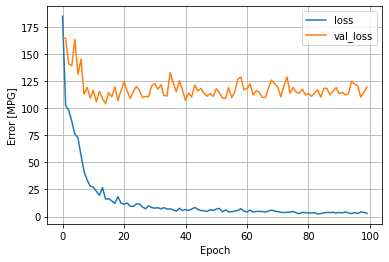

In [148]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    #plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)


plot_loss(history)


In [145]:
preds = dnn_model.predict(np.array(X_test)).flatten()


51/51 [==============================] - 2s 27ms/step


In [147]:
preds/10**37

array([3.653239729496534, nan, nan, ..., nan, nan, 2.9779298028995904],
      dtype=object)

In [123]:
len(preds)

1614

In [134]:
y_train.max()

100.0

In [79]:
import pandas as pd
import numpy as np
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

In [80]:
model = tf.keras.Sequential()
model.add(Dense(512))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))

In [81]:
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [84]:
model.fit(X_train_scaled, y_train,
          batch_size=128,
          epochs=100,
          verbose=0,
          validation_data=(X_test_scaled, y_test))

TypeError: 'NoneType' object is not callable